In [1]:
## build researcher events, student events, and self-study events
## researcher are simply those with NH citations

In [2]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sys
import pandas as pd
import time
import datetime
import numpy as np
import datetime
import os
from pathlib import Path
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from nanoHUB.application import Application
from nanoHUB.configuration import ClusteringConfiguration
from nanoHUB.pipeline.geddes.data import get_default_s3_client
from nanoHUB.dataaccess.lake import S3FileMapper

from nanoHUB.clustering.infra import get_mike_only_clustered_users, get_xufeng_only_clustered_users, get_mike_xufeng_clustered_users
from nanoHUB.clustering.infra import get_number_of_clusters_for_sem,create_clusters_repository, add_cluster_info, get_all_clustered_users, get_all_self_study_users, get_all_self_identified_users
from nanoHUB.clustering.infra import filter_by_semester, filter_by_algorithm

application = Application.get_instance()
nanohub_db = application.new_db_engine('nanohub')
nanohub_metrics_db = application.new_db_engine('nanohub_metrics')

s3_client = get_default_s3_client(application)
processed_mapper = S3FileMapper(s3_client, ClusteringConfiguration().bucket_name_processed)
derived_data_file_path = 'derived_data_for_users.csv'

nanoHUB - Serving Students, Researchers & Instructors


In [4]:
START_YEAR = 2008
END_YEAR = 2022
prod_flag = True
dev_flag = False

In [5]:
pd.set_option('display.max_columns', None)

cwd = os.getcwd()
print(cwd)
cache_dir = Path(cwd + '/cached_data')

/home/saxenap/nanoHUB/nanoHUB/pipeline/plotting


In [6]:
clusters = create_clusters_repository(application, ClusteringConfiguration().bucket_name_processed)

In [7]:
def list_to_csv(list_vals: list, path: Path):
    df = pd.DataFrame()
    df['values'] = list_vals
    df.to_csv(path, index = None)

## Classroom activity plots

In [9]:
## calculate classes per semester
year = START_YEAR
algs = ['mike']
semester_list = ['Spring','Fall']

num_clusters_bysem = []
num_cumulative_classes = 0
num_cumulative_classes_bysem = []
students_bysem = []
months_sems = []
num_students_bysem = []
num_unique_students_bysem = []
today = datetime.datetime.today()
cumulative_users = []
num_cumulative_users_bysem = []
unique_students = set()
num_unique_cumulative_users_bysem = []
num_cumulative_users = 0
num_unique_cumulative_users = 0
unique_users_2021 = set()
num_clusters_2021 = 0
all_unique_users = set()
num_all_classes = 0
i = 0
num_users_2021 = 0

all_users_df = processed_mapper.read(derived_data_file_path, low_memory=False)
i=0
for alg in algs:
    alg_df = filter_by_algorithm(all_users_df, alg)
    for year in range(START_YEAR, END_YEAR):
        # print(year)
        for semester in semester_list:
            # i = i+1
            # if i > 2:
            #     raise
            semester = semester.lower()
            if semester == 'fall':
                months_sems.append(datetime.datetime.strptime(str(year)+'-07-01', '%Y-%m-%d') )
                users = clusters.get(alg, datetime.date(year, 7, 2), datetime.date(year, 12, 31))

            elif semester == 'spring':
                months_sems.append(datetime.datetime.strptime(str(year)+'-01-01', '%Y-%m-%d') )
                users = clusters.get(alg, datetime.date(year, 1, 1), datetime.date(year, 7, 1))
            
            
            num_clusters = get_number_of_clusters_for_sem(clusters, alg, semester, year)
            num_clusters_bysem.append(num_clusters)
            
            num_cumulative_classes = num_cumulative_classes + num_clusters
            num_cumulative_classes_bysem.append(num_cumulative_classes)
            
            result_list = []
            result_set = set()
            for column in users.columns:
                vals1 = users[column].tolist()
                vals = [x for x in vals1 if pd.notnull(x)]
                result_list.extend(vals)
                result_set = result_set.union(vals)
            
            num_all_classes = num_all_classes + num_clusters
            all_unique_users = all_unique_users.union(result_set)
            # print([item for item, count in collections.Counter(result_list).items() if count > 1])
            num_users = users[users.columns].notnull().sum(axis=1).sum()
            students_bysem.extend(result_list)
            num_students_bysem.append(num_users)
            
            num_unique_students = len(result_set)
            num_unique_students_bysem.append(num_unique_students) 
            
            
            num_cumulative_users = num_cumulative_users + num_users
            num_cumulative_users_bysem.append(num_cumulative_users)
            
            num_unique_cumulative_users = num_unique_cumulative_users + num_unique_students
            num_unique_cumulative_users_bysem.append(num_unique_cumulative_users)
            # print(num_cumulative_users, ' : ', num_unique_cumulative_users)
            # print('***********************************')
            if year == 2021:
                unique_users_2021 = unique_users_2021.union(result_set)
                num_clusters_2021 = num_clusters_2021 + num_clusters
                num_users_2021 = len(result_list) + num_users_2021
                
                i = i+1
                if i == 2:
                    print('num_users_2021: ', num_users_2021)
                    print('unique_users_2021: ', len(unique_users_2021))
                    print('num_clusters_2021: ', num_clusters_2021)
        year += 1

print('all_unique_users:', len(all_unique_users))
print('num_all_classes: ', num_all_classes)
# display(months_sems)
# display(num_clusters_bysem)
# display(students_bysem)


num_users_2021:  9143
unique_users_2021:  8937
num_clusters_2021:  460
all_unique_users: 64402
num_all_classes:  3583


In [8]:
months_sems2 = [str(i.year)+'-0'+str(i.month) for i in months_sems]

In [9]:
months_sems_plot = months_sems2
num_clusters_bysem_plot = num_clusters_bysem
students_bysem_plot = students_bysem
num_students_bysem_plot = num_students_bysem

In [21]:
#dump out all the class data into a directory we use for total numbers , also from other scripts
pathsave=cwd+'/total_data/'

cache_track = pd.DataFrame()
cache_track['date'] = months_sems_plot
cache_track['num_clusters_bysem'] = num_clusters_bysem_plot
cache_track['num_cumulative_classes'] = cumulative_classes_plot

cache_track.to_csv(pathsave+'Classes_mike.csv')


In [20]:
display(cache_track.head())
display(cache_track.tail())

,months_sems,num_clusters_bysem,months_sems2,num_cumulative_classes
0,2008-01,66,2008-01-01,66
1,2008-07,45,2008-07-01,111
2,2009-01,47,2009-01-01,158
3,2009-07,51,2009-07-01,209
4,2010-01,90,2010-01-01,299


,months_sems,num_clusters_bysem,months_sems2,num_cumulative_classes
23,2019-07,158,2019-07-01,2680
24,2020-01,242,2020-01-01,2922
25,2020-07,201,2020-07-01,3123
26,2021-01,246,2021-01-01,3369
27,2021-07,214,2021-07-01,3583


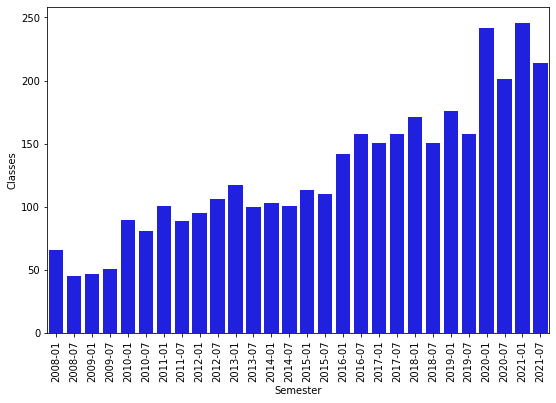

In [17]:
## plot two bar plots
plt.figure(figsize=(9,6))

g = sns.barplot(months_sems_plot, num_clusters_bysem_plot, color='blue');
g.set_xticklabels(months_sems_plot, rotation=90)

plt.xlabel('Semester')
plt.ylabel('Classes')

## specify algorithm name
if dev_flag == True:
    plt.savefig(cwd+'/plots_local/300_classclust_semester_mike_classes.eps', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300_classclust_semester_mike_classes.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300_classclust_semester_mike_classes.png', dpi=300, bbox_inches='tight')
elif prod_flag == True:
    plt.savefig(cwd+'/plots_production/300_classclust_semester_mike_classes.eps', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300_classclust_semester_mike_classes.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300_classclust_semester_mike_classes.png', dpi=300, bbox_inches='tight')
else:
    print('no printing flag is active')

# plt.figure(figsize=(9,6))
# g = sns.barplot(months_sems_plot, num_students_bysem_plot, color='green');
# g.set_xticklabels(months_sems_plot, rotation=90)

# plt.xlabel('Semester')
# plt.ylabel('Students')

# if dev_flag == True:
#     plt.savefig(cwd+'/plots_local/300_classclust_semester_mike_participants.eps', dpi=300, bbox_inches='tight')
#     plt.savefig(cwd+'/plots_local/300_classclust_semester_mike_participants.pdf', dpi=300, bbox_inches='tight')
#     plt.savefig(cwd+'/plots_local/300_classclust_semester_mike_participants.png', dpi=300, bbox_inches='tight')
# elif prod_flag == True:
#     plt.savefig(cwd+'/plots_production/300_classclust_semester_mike_participants.eps', dpi=300, bbox_inches='tight')
#     plt.savefig(cwd+'/plots_production/300_classclust_semester_mike_participants.pdf', dpi=300, bbox_inches='tight')
#     plt.savefig(cwd+'/plots_production/300_classclust_semester_mike_participants.png', dpi=300, bbox_inches='tight')
# else:
#     print('no printing flag is active')

In [11]:

semester_list = ['Spring','Fall','Summer']
# group Spring and Summer together

months_sems3 = []

for year in range(START_YEAR, END_YEAR):
    for i in semester_list:
        if i == 'Fall':
            months_sems3.append(datetime.datetime.strptime(str(year)+'-07-01', '%Y-%m-%d') )
        elif i == 'Spring':
            months_sems3.append(datetime.datetime.strptime(str(year)+'-01-01', '%Y-%m-%d') )


In [12]:

months_sems_plot2 = months_sems3
cumulative_sem_students_plot = num_cumulative_users_bysem
unique_students_plot = num_unique_cumulative_users_bysem
cumulative_classes_plot = num_cumulative_classes_bysem


[WARNING] [backend_ps - matplotlib.backends.backend_ps]: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque. [backend_ps._is_transparent:303]


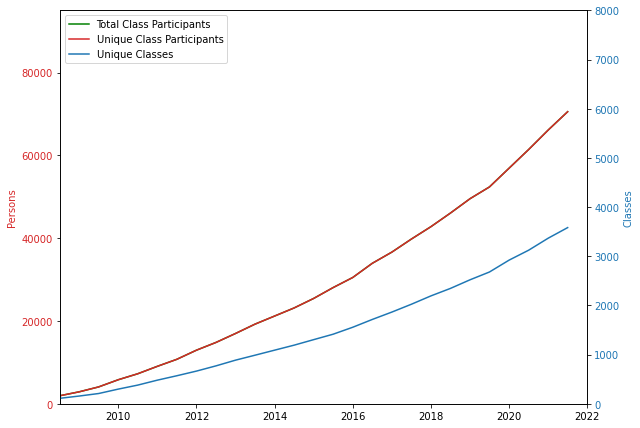

In [13]:
# plot cumulative class and student count
fig, ax1 = plt.subplots(figsize=(9,6))

color = 'tab:red'
ax1.set_ylabel('Persons', color=color)
p1, = ax1.plot(months_sems_plot2, \
         cumulative_sem_students_plot, color='Green',label='Total Class Participants')
p2, = ax1.plot(months_sems_plot2, unique_students_plot, color=color, label='Unique Class Participants')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Classes', color=color) # we already handled the x-label with ax1
p3, = ax2.plot(months_sems_plot2,cumulative_classes_plot, color=color,label='Unique Classes')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.xlim([datetime.datetime(2008,7,1), datetime.datetime(2022,1,1)])

ax1.set_ylim([0, 95000])
ax1.grid(False)
ax2.set_ylim([0, 8000])
ax2.grid(False)

# add legend
plt.legend(handles=[p1,p2,p3],loc=2)

if dev_flag == True:
    plt.savefig(cwd+'/plots_local/300_classclust_semester_cumulative_combined.eps', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300_classclust_semester_cumulative_combined.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300_classclust_semester_cumulative_combined.png', dpi=300, bbox_inches='tight')
elif prod_flag == True:
    plt.savefig(cwd+'/plots_production/300_classclust_semester_cumulative_combined.eps', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300_classclust_semester_cumulative_combined.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300_classclust_semester_cumulative_combined.png', dpi=300, bbox_inches='tight')
else:
    print('no printing flag is active')

In [14]:
## create a df and save as csv
s_df_cumulative = pd.DataFrame()
s_df_cumulative['year_month'] = months_sems_plot2
s_df_cumulative['total_class_participants'] = cumulative_sem_students_plot
s_df_cumulative['unique_class_participants'] = unique_students_plot
s_df_cumulative['unique classes'] = cumulative_classes_plot

In [15]:
print(s_df_cumulative.shape)
print(s_df_cumulative.tail(5))

(28, 4)
   year_month  total_class_participants  unique_class_participants  \
23 2019-07-01                     52367                      52367   
24 2020-01-01                     56907                      56907   
25 2020-07-01                     61394                      61394   
26 2021-01-01                     66132                      66132   
27 2021-07-01                     70537                      70537   

    unique classes  
23            2680  
24            2922  
25            3123  
26            3369  
27            3583  


In [16]:
s_df_cumulative.to_csv(cwd+'/cached_data/cumulative_class_clust_df.csv')